In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
# from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import models, transforms # datasets, 
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import cv2
import torch.utils.data as data
from random import shuffle
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
# import pretrained_models.densenet  as dn
from glob import glob
import pandas as pd
from tqdm import tqdm

from collections import OrderedDict
from pycocotools import mask as coco_mask

from box import  rle_decode, get_image_boxes
from dataset import ATTR_FOR_CLASSIFY, MyDataset, built_attr2label, imshow
plt.ion()   # interactive mode

In [2]:
img_size = 224
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),  # 224 for resnet and densenet
        transforms.RandomRotation(degrees=15),
        #transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # mean, std
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
root = '../datasets/imaterialist/'
train_csv = os.path.join(root, 'attribute_label', 'for_classify_train.csv')
val_csv = os.path.join(root, 'attribute_label', 'for_classify_val.csv')

In [4]:
batch_sizes = {"train":48, "val":48}
train_dataset = MyDataset(root, train_csv, ATTR_FOR_CLASSIFY, transform=data_transforms["train"])
val_dataset = MyDataset(root, val_csv, ATTR_FOR_CLASSIFY, transform=data_transforms["val"])
image_datasets = {"train":train_dataset, "val":val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_sizes[x],
                                             shuffle=(x=="train"), num_workers=4)
              for x in ["train", "val"]}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
# class_names = image_datasets["train"].classes
# print(class_names)

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [5]:
val_iter = iter(dataloaders['val'])

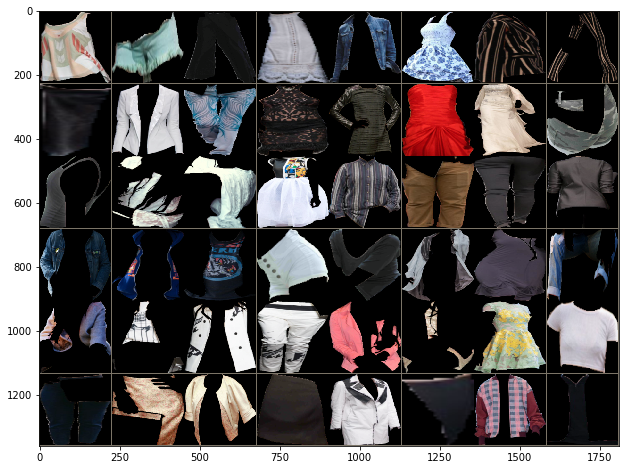

In [6]:
# Get a batch of training data
inputs, classes = next(val_iter)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=None)#[x for x in classes]

In [5]:
def val_model(model, criterions):
    model.train(False)
    since = time.time()
    running_loss = 0.0
    running_corrects = 0
    result = []
    ground_truth = []
    tests = []
    for data in tqdm(dataloaders["val"]):
        inputs, labels = data
        ground_truth.append(labels)
        #for label in labels:
            #ground_truth.append(label)
        if use_gpu:
            inputs = inputs.to('cuda')
            labels = [label.to('cuda') for label in labels]
        with torch.no_grad():
            outputs = model(inputs)
        preds = []
        for i in range(len(label_index)-1):
            _, pred = torch.max(outputs[:, label_index[i]:label_index[i+1]], 1)
            preds.append(pred)
        loss = 0
        i = 0
        for criterion, label in zip(criterions, labels):
            loss += criterion(outputs[:, label_index[i]:label_index[i+1]], label)
            i += 1
        assert i == len(preds)
        loss = loss/i
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        # accuracy
        corrects = torch.zeros_like(preds[0], device='cpu')
        for pred, label in zip(preds, labels):
            corrects += (pred==label).to('cpu').long()
        running_corrects += torch.sum(corrects).item()/len(preds)
        #print(preds.cpu().numpy())
#         preds = preds.cpu().numpy()
        result.append([pred.to('cpu') for pred in preds])
        #for p in preds:
            #result.append(p)
        
    loss = running_loss / len(val_dataset)
    acc = running_corrects / len(val_dataset)
    print('Loss: {:.4f} Acc: {:.4f}'.format(
        loss, acc))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return result, ground_truth, tests

In [7]:
#model = torchvision.models.densenet169(pretrained=False)
# model = dn.densenet169(pretrained=False)
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 3)
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

attr2label = built_attr2label(ATTR_FOR_CLASSIFY)
num_out = 0
label_index = [0]
for key in attr2label.keys():
    num_out += len(attr2label[key])
    label_index.append(num_out)
print(num_out, label_index)
model.fc = nn.Linear(num_ftrs, num_out)

model.load_state_dict(torch.load("../train_logs/garment_attribute_classify/ResNet_cycle_epochbest.pth"))

In [10]:
if use_gpu:
    model.cuda()

criterions = [nn.CrossEntropyLoss() for _ in val_dataset.attr2label.keys()]

In [11]:
# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

result, ground_truth, test = val_model(model, criterions)

100%|██████████| 37/37 [01:55<00:00,  3.13s/it]

Loss: 0.5315 Acc: 0.8169
Training complete in 1m 56s


In [28]:
correct_count = 0
for b in range(len(result)):
    preds = result[b]
    labels = ground_truth[b]
    corrects = torch.zeros_like(preds[0], device='cpu')
    for pred, label in zip(preds, labels):
        corrects += (pred==label).to('cpu').long()
    correct_count += torch.sum(corrects==len(preds) ).item() 
correct_count/len(val_dataset)

0.08073817762399077

In [33]:
result_dict = {}
gt_dict = {}
for key in val_dataset.attr2label.keys():
    result_dict[key] = []
    gt_dict[key] = []
for b in range(len(result)):
    preds = result[b]
    labels = ground_truth[b]
    for i, key in enumerate(val_dataset.attr2label.keys()):
        result_dict[key].extend(preds[i].numpy())
        gt_dict[key].extend(labels[i].numpy())

In [39]:
for key in val_dataset.attr2label.keys():   
    cm = confusion_matrix(gt_dict[key], result_dict[key])
    cr = classification_report(gt_dict[key], result_dict[key])
    print(key,':  \n', cm, '\n', cr)

length :  
 [[159  39   5   1  24   0   0   0   2  15   3]
 [ 37 321  30   2  25   0   0   0   1   3   0]
 [ 13  56  44   3  21   0   0   0   0   0   0]
 [ 10  11   3  26  32   0   0   0   0   0   0]
 [ 31  14   3  17 196  13   4   0   6   3   5]
 [  5   0   0   1  43  16   6   0   6   1   2]
 [  5   2   0   0  27   7  20   7   1   2   7]
 [  2   1   0   0  10   5   4   7   6   3   5]
 [  4   1   1   0  11   2   1   2  14  15   4]
 [ 15   1   0   2   8   0   0   0   8 166  21]
 [  3   1   0   0   2   1   0   0   2  18  52]] 
               precision    recall  f1-score   support

           0       0.56      0.64      0.60       248
           1       0.72      0.77      0.74       419
           2       0.51      0.32      0.39       137
           3       0.50      0.32      0.39        82
           4       0.49      0.67      0.57       292
           5       0.36      0.20      0.26        80
           6       0.57      0.26      0.35        78
           7       0.44      0.16  

## inference 

In [1]:
import numpy as np
import os
import torch
import torchvision
from torchvision import models, transforms
import pandas as pd
from tqdm import tqdm

from dataset import ATTR_FOR_CLASSIFY, MyDataset, built_attr2label, imshow

In [2]:
# submiss_wo_attribute_df = pd.read_csv('../train_logs/ftCOCO_noWarmUp/answer_wo_attribute.csv')
# submiss_wo_attribute_df.head()

In [3]:
img_size = 224
test_transform=transforms.Compose([transforms.Resize((img_size, img_size)),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [4]:
root = '../datasets/imaterialist/'
csv_path = '../train_logs/ftCOCO_noWarmUp/answer_wo_attribute.csv'
ans_df = pd.read_csv(csv_path)

In [5]:
csv_test = ans_df[ans_df['ClassId']<13]
len(csv_test)

4108

In [6]:
test_dataset = MyDataset(root, csv_test, ATTR_FOR_CLASSIFY, transform=test_transform, del_bg=True, infer=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=48, shuffle=False, num_workers=4)
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [7]:
test_iter = iter(test_loader)

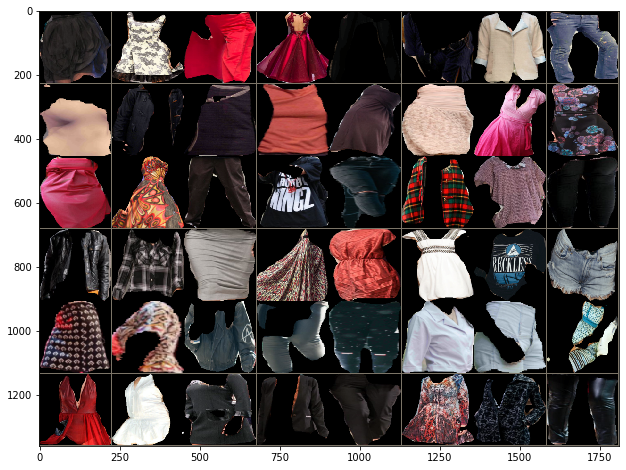

In [8]:
# Get a batch of training data
inputs, classes = next(test_iter)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=None)#[x for x in classes]

In [9]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features

attr2label = test_dataset.attr2label
num_out = 0
label_index = [0]
for key in attr2label.keys():
    num_out += len(attr2label[key])
    label_index.append(num_out)
print(num_out, label_index)
model.fc = torch.nn.Linear(num_ftrs, num_out)

model.load_state_dict(torch.load("../train_logs/garment_attribute_classify/ResNet_cycle_epochbest.pth"))

if use_gpu:
    model.cuda()
model.eval()

print("done!")

106 [0, 11, 15, 21, 24, 43, 49, 61, 73, 80, 88, 97, 102, 104, 106]
done!


In [10]:
result = []
for data in tqdm(test_loader):
    inputs, labels = data
    if use_gpu:
        inputs = inputs.to('cuda')
        labels = [label.to('cuda') for label in labels]
    with torch.no_grad():
        outputs = model(inputs)
    preds = []
    for i in range(len(label_index)-1):
        _, pred = torch.max(outputs[:, label_index[i]:label_index[i+1]], 1)
        preds.append(pred)
    result.append([pred.to('cpu') for pred in preds])

100%|██████████| 86/86 [11:51<00:00,  7.65s/it]


In [ ]:
result_dict = {}
gt_dict = {}
for key in val_dataset.attr2label.keys():
    result_dict[key] = []
    gt_dict[key] = []
for b in range(len(result)):
    preds = result[b]
    labels = ground_truth[b]
    for i, key in enumerate(val_dataset.attr2label.keys()):
        result_dict[key].extend(preds[i].numpy())
        gt_dict[key].extend(labels[i].numpy())

In [25]:
result_dict = {}
for key in test_dataset.attr2label.keys():
    result_dict[key] = []

for preds in result:
    for i, key in enumerate(test_dataset.attr2label.keys()):
        result_dict[key].extend(preds[i].numpy())

In [49]:
ann_id_dict = {}
index_list = list(csv_test.index)
for i, index in enumerate(index_list):
    ann_id_dict[index] = []
    for key in test_dataset.classes_dict.keys():
        for ann_id, item in  test_dataset.attr2label[key].items():
            if item == result_dict[key][i]:
                if ann_id != 92:
                    ann_id_dict[index].append(ann_id)
                break

In [11]:
def get_class_id(cat_id, att_ids):
    """
    Get concatenated ClassId
    Args:
        cat_id: int, index for the apparel category
        att_ids: [int], list of apparel attributes
    Returns:
        class_id: string, e.g. "2_10_91_55"
    """
    class_id = []
    class_id.append(cat_id)
    att_ids.sort()  # need to be sorted before concatenation
    class_id.extend(att_ids)
    return "_".join([str(i) for i in class_id])

In [62]:
for key in ann_id_dict.keys():
    class_id = get_class_id(ans_df.loc[key, "ClassId"], ann_id_dict[key])
    ans_df.loc[key, "ClassId"] = class_id

In [64]:
ans_df.to_csv(csv_path.replace('answer_wo_attribute.csv', 'answer_attribute.csv'), index=False)